### Defining a Convolution Layer
In the cell below we define a simple convolution layer that aggregates from a $k$ hop neighborhood in an arbritrary graph. We have 5 basic steps.
1. Add self-loops to the graph so that each update works on the neighboring information as well as the information stored in the node itself
2. Apply a learnable layer
3. Compute a normalization
4. Normalize features
5. Aggregate information from neighbors

In [27]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from tqdm import tqdm

# Define the convlutional layer
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, k=1):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)
        
        # k represents the number of hops that we aggreate information from
        self.k = k

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Run message passing across the k-hop neighborhoods of each node
        for i in range(self.k):
            # Step 2: Linearly transform node feature matrix only when all aggregation is complete.
            if i == self.k - 1:
                x = self.lin(x)

            # Step 3: Compute normalization.
            row, col = edge_index
            deg = degree(col, x.size(0), dtype=x.dtype)
            deg_inv_sqrt = deg.pow(-0.5)
            norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

            # Step 4-5: Start propagating messages.
            x = self.propagate(edge_index, x=x, norm=norm)
        return x

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

### Overall Model
Below we load the dataset using PyG's internal libraries. We use the standard Cora dataset of citation networks which is a useful baseline for all models. In addition, we define the model using the convolution layers from above. These can be swapped in and out for any of the models defined in the framework. Here we can adjust the $k$-hop neighborhood we pull data from and the $x$-sized hidden layer.

In [28]:
import os.path as osp

import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GNNExplainer, ARMAConv

# Loading in standard Cora citation dataset into current directory
dataset = 'Cora'
path = osp.join('.', 'data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

# Define the model
class Net(torch.nn.Module):
    def __init__(self, k=1, x=16):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, x, k)
        self.conv2 = GCNConv(x, x, k)
        self.conv3 = GCNConv(x, dataset.num_classes, k)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

### Training the Model
Below we first load the data into the gpu using pytorch's usual functionality. Then we train the model for 500 epochs while maintaining the best test AUC throughout.

In [36]:
# Load everything onto the gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# k is the number of aggregation hops and x is the hidden feature size
model = Net(k=10, x=8).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

pbar = tqdm(range(0, 501))
best_loss = 100
for epoch in pbar:
    # Training step
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Testing step
    model.eval()
    test_loss = F.nll_loss(log_logits[data.test_mask], data.y[data.test_mask]).item()
    best_loss = test_loss if test_loss < best_loss else best_loss
    pbar.set_description('Best Test Lost: %.3f' % (best_loss))

Best Test Lost: 0.923: 100%|██████████| 501/501 [00:14<00:00, 34.06it/s]


### Explaining our Model
Since the model is defined and trained within the PyG framework, we can apply any number of analysis tools from its ecosystem. The one below is called GNNExplainer and is useful in determing edge and node feature importance.

Explain node 10: 100%|██████████| 1000/1000 [00:10<00:00, 98.15it/s]


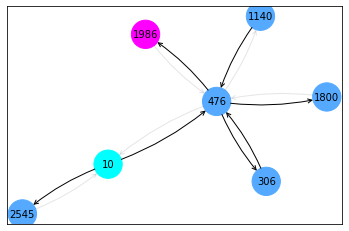

In [33]:
# Define GNNExplainer and run it for node 10
explainer = GNNExplainer(model, epochs=1000, num_hops=2)
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

For more info visit https://github.com/rusty1s/pytorch_geometric. Example above was pieced together from there along with modifications.